# Initialization

To see how different initializations lead to different results.

In [228]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

from tools.activation_function import sigmoid, sigmoid_derivative, ReLU, ReLU_derivative, tanh, tanh_derivative

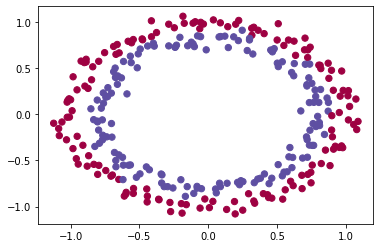

In [282]:
def load_dataset ():
    # training set
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    
    # testing set
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    
    # plot
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);

    # handle data
    train_X, test_X = train_X.T, test_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    
    return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = load_dataset()

# 1 - Neural Network Model

**build 3-layer NN, try different initialization methods**

initialization: 
1. Zeros initialization
2. Random initialization
3. He initialization

In [362]:
def forward_propagation (X, params):
    # 3 Layers (X -> A1(relu) -> A2(relu) -> A3(sigmoid))
    W1 = params['W1']
    W2 = params['W2']
    W3 = params['W3']
    
    b1 = params['b1']
    b2 = params['b2']
    b3 = params['b3']
    
    # Layer 1
    A1 = ReLU(np.dot(W1.T, X) + b1)
    # Layer 2
    A2 = ReLU(np.dot(W2.T, A1) + b2)
    # Layer 3
    A3 = sigmoid(np.dot(W3.T, A2) + b3)

    A = {
        'A0': X,
        'A1': A1,
        'A2': A2,
        'A3': A3
    }

    return A

def cost_function (A, y):
    A3 = A['A3']
    m = y.shape[1]
    loss = -y * np.log(A3) - (1 - y) * np.log(1 - A3)
    J = (1. / m) * np.nansum(loss)

    return J

def backward_propagation (A, y, params):
    m = y.shape[1]
    # dJ_dZ3 = A3 - y
    dJ_dZ3 = A['A3'] - y
    dJ_dW3 = (1 / m) * np.dot(A['A2'], dJ_dZ3.T)
    dJ_db3 = (1 / m) * np.sum(dJ_dZ3, axis = 1, keepdims = True)
    
    # dJ_dZ2
    dJ_dZ2 = np.dot(params['W3'], dJ_dZ3) * ReLU_derivative(A['A2'])
    dJ_dW2 = (1 / m) * np.dot(A['A1'], dJ_dZ2.T)
    dJ_db2 = (1 / m) * np.sum(dJ_dZ2, axis = 1, keepdims = True)
    
    # dJ_dZ1
    dJ_dZ1 = np.dot(params['W2'], dJ_dZ2) * ReLU_derivative(A['A1'])
    dJ_dW1 = (1 / m) * np.dot(A['A0'], dJ_dZ1.T)
    dJ_db1 = (1 / m) * np.sum(dJ_dZ1, axis = 1, keepdims = True)
    
    grads = {
        'dJ_dW3': dJ_dW3,
        'dJ_db3': dJ_db3,
        'dJ_dW2': dJ_dW2,
        'dJ_db2': dJ_db2,
        'dJ_dW1': dJ_dW1,
        'dJ_db1': dJ_db1
    }
    
    return grads
    
def update_derivatives (params, grads, alpha, L_len):
    for l in range(1, L_len):
        params['W' + str(l)] -= alpha * grads['dJ_dW' + str(l)]
        params['b' + str(l)] -= alpha * grads['dJ_db'+ str(l)]
    
    return params

def plot_cost (J_arr, alpha):
    plt.plot(J_arr)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(alpha))
    plt.show()
    
    
def plot_decision_boundary (model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec (params, X):
    A= forward_propagation(X, params)
    A3 = A['A3']
    return np.round(A3)

def predict (X, y, params):
    A = forward_propagation(X, params)
    A3 = A['A3']
    m = A3.shape[1]
    
    y_predict = np.round(A3)
    
    # 精确度预测
    accuracy = 1 - np.sum(abs(y_predict - y)) / m
    print("===== Accuracy: " + str(accuracy) + '% =====')
    
    # 绘图
    plot_decision_boundary(lambda x: predict_dec(params, x.T), X, y)

In [375]:
class NN_Model ():
    def __init__(self, X, y, Layers, init_type):
        self.X = X
        self.y = y
        
        self.Layers = Layers
        self.L_len = len(Layers)
        self.m = X.shape[1]
        
        # hyperparameters:
        self.alpha = 0.01
        self.iterations = 10000
        
        # 选择初始化parameters类型
        self.init_type = init_type
        

    def init_parameters_zeros (self):
        print('===== Zeros initialization =====')
        parameters = {}
        for i in range(1, len(self.Layers)):
            parameters['W' + str(i)] = np.zeros(shape = (self.Layers[i - 1], self.Layers[i]))
            parameters['b' + str(i)] = np.zeros(shape = (self.Layers[i], 1))
        return parameters
        
    def init_parameters_random (self):
        print('===== Random initialization =====')
        print('===== 初始化均乘以10: weights * 10, 证明较大的随机初始值, 会导致【梯度消失/梯度爆炸】问题 =====')
        
        print('===== 如果仅是高斯分布的初始值, 其实就还好 =====')
        parameters = {}
        for i in range(1, len(self.Layers)):
            parameters['W' + str(i)] = np.random.randn(self.Layers[i - 1], self.Layers[i]) * 10
            parameters['b' + str(i)] = np.zeros(shape = (self.Layers[i], 1))
        return parameters
    
    def init_parameters_he (self):
        print('===== He initialization =====')
        parameters = {}
        for i in range(1, len(self.Layers)):
            # 缩放因子
            he = np.sqrt(2. / self.Layers[i - 1])
            parameters['W' + str(i)] = np.random.randn(self.Layers[i - 1], self.Layers[i]) * he
            parameters['b' + str(i)] = np.zeros(shape = (self.Layers[i], 1))
        return parameters

    def training (self):
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        
        J_arr = []
        
        # 1. init parameters
        params = {}
        if self.init_type == 'zero':
            params = self.init_parameters_zeros()
        elif self.init_type == 'random':
            params = self.init_parameters_random()
        elif self.init_type == 'he':
            params = self.init_parameters_he()


        for i in range(self.iterations):
            # 2. Forward propagation
            A = forward_propagation(X, params)

            # 3. Loss
            if i % 1000 == 0:
                J = cost_function(A, y)
                J_arr.append(J)

            # 4. backward_propagation
            grads = backward_propagation (A, y, params)

            # 5. update_derivatives
            params = update_derivatives (params, grads, alpha, L_len)
        
        # plot cost
        plot_cost (J_arr, alpha)
        
        # return Weights and bias
        return params
        

# 2 - Zero initialization


weights 设置为0, 肯定是不行的

这样我们训练得出的activation值也都是0了


===== Zeros initialization =====


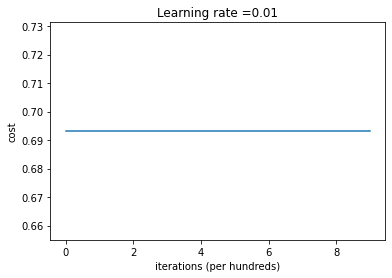

===== Accuracy: 0.5% =====


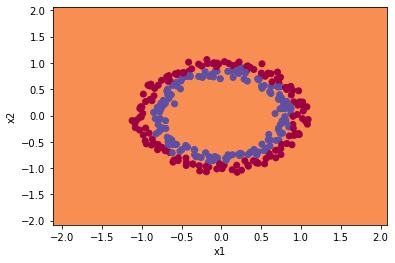

In [376]:
Layers = [train_X.shape[0], 10, 5, 1]

NN_zero = NN_Model(train_X, train_Y, Layers, 'zero')
params_zero = NN_zero.training()

predict(train_X, train_Y, params_zero)

# 3 - Random initialization


【选值】 weights 随机值 * 10倍 (scaled by *10) 

【目标】选取较大的随机数(too large weights) 作为初始值时, 会出现 **梯度消失/梯度爆炸** 问题。

【梯度消失/梯度爆炸】Poor initialization can lead to vanishing/exploding gradients, which also slows down the optimization algorithm. 


```python
# 收敛速度非常的慢, 此时是0.01学习率, 换成0.1 就好些了
Layers = [train_X.shape[0], 3, 3, 1]
Layers = [train_X.shape[0], 4, 2, 1]

# 正常
Layers = [train_X.shape[0], 10, 5, 1]
Layers = [train_X.shape[0], 10, 10, 1]
```

===== Random initialization =====
===== 初始化均乘以10: weights * 10, 证明较大的随机初始值, 会导致【梯度消失/梯度爆炸】问题 =====
===== 如果仅是高斯分布的初始值, 其实就还好 =====


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


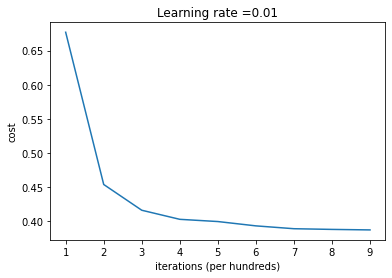

===== Accuracy: 0.7966666666666666% =====


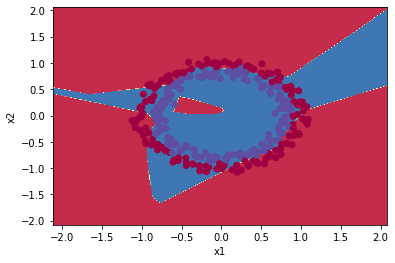

In [380]:
Layers = [train_X.shape[0], 10, 5, 1]

NN_random = NN_Model(train_X, train_Y, Layers, 'random')
params_random = NN_random.training()

predict(train_X, train_Y, params_random)


# 4 - He initialization

【增加缩放因子】$\frac{2}{prevLayerNum}^{\frac{1}{2}}$

- prevLayerNum 上一层的节点个数
- (2 / prevLayerNum) 的开根号

【代码】

```python
def init_parameters_he (self):
    parameters = {}
    for i in range(1, len(self.Layers)):
        # 缩放因子
        he = np.sqrt(2. / self.Layers[i - 1])
        # 随机数 * 缩放因子
        parameters['W' + str(i)] = np.random.randn(self.Layers[i - 1], self.Layers[i]) * he
        parameters['b' + str(i)] = np.zeros(shape = (self.Layers[i], 1))
    return parameters
```

===== He initialization =====


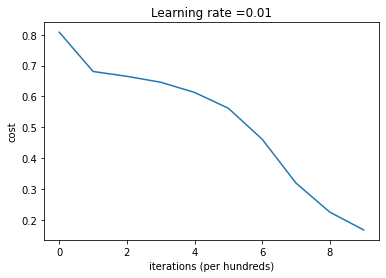

===== Accuracy: 0.98% =====


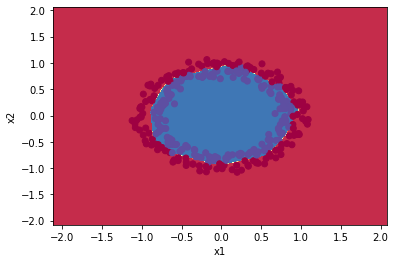

In [370]:
Layers = [train_X.shape[0], 10, 5, 1]

NN_he = NN_Model(train_X, train_Y, Layers, 'he')
params_he = NN_he.training()

predict(train_X, train_Y, params_he)

# 5 - Conclusions

#### 1. Zero initialization
- 不可取, 神经网络的所有值都是0, 无法收敛, 无法计算

#### 2. Random initialization
- 不能选取 较大的随机值, 会出现最后一层计算sigmoid超出界限, 无穷大情况
- 会出现**梯度消失/梯度爆炸**

#### 3. He initialization
- weights 随机数 * 缩放因子(根据上一层结点数目来计算)
- 推荐使用该方法